## Initialize the Env

In [2]:

import functools
import jax
from jax import numpy as jp
import numpy as np
from typing import Dict
import wandb

from brax import envs
from brax.envs.base import PipelineEnv, State
from brax.training.agents.ppo import train as ppo
from brax.io import model
from brax.io import mjcf as mjcf_brax

from dm_control import mjcf as mjcf_dm

import mujoco
from mujoco import mjx
import os

import yaml
from typing import Dict, Text

from mjcf_vnl import rodent

os.environ['XLA_FLAGS'] = (
    '--xla_gpu_enable_triton_softmax_fusion=true '
    '--xla_gpu_triton_gemm_any=True '
    '--xla_gpu_enable_async_collectives=true '
    '--xla_gpu_enable_latency_hiding_scheduler=true '
    '--xla_gpu_enable_highest_priority_async_stream=true '
)



# ## Load the model

# ## TODO:
# 
# - Check the healthy z-range of the rodent. Now the training
#     - Check mj_data and how to pull out kinematics of the simulations
# - Check the `brax.envs` and how I can pass the custom parameters

# In[3]:


def load_params(param_path: Text) -> Dict:
    with open(param_path, "rb") as file:
        params = yaml.safe_load(file)
    return params


params = load_params("params/params.yaml")


class Rodent(PipelineEnv):

  def __init__(
      self,
      forward_reward_weight=10,
      ctrl_cost_weight=0.1,
      healthy_reward=1.0,
      terminate_when_unhealthy=True,
      healthy_z_range=(0.5, 0.0),
      reset_noise_scale=1e-2,
      exclude_current_positions_from_observation=True,
      **kwargs,
  ):
    # Load the rodent model via dm_control
    dm_rodent = rodent.Rodent()
    physics = mjcf_dm.Physics.from_mjcf_model(dm_rodent.mjcf_model)
    # mj_model = mujoco.MjModel.from_xml_path(params["XML_PATH"])
    mj_model = physics.model.ptr
    mj_model.opt.solver = mujoco.mjtSolver.mjSOL_CG
    mj_model.opt.iterations = 6
    mj_model.opt.ls_iterations = 6

    sys = mjcf_brax.load_model(mj_model)

    physics_steps_per_control_step = 5
    
    kwargs['n_frames'] = kwargs.get(
        'n_frames', physics_steps_per_control_step
    )
    kwargs['backend'] = 'mjx'

    super().__init__(sys, **kwargs)

    self._forward_reward_weight = forward_reward_weight
    self._ctrl_cost_weight = ctrl_cost_weight
    self._healthy_reward = healthy_reward
    self._terminate_when_unhealthy = terminate_when_unhealthy
    self._healthy_z_range = healthy_z_range
    self._reset_noise_scale = reset_noise_scale
    self._exclude_current_positions_from_observation = (
        exclude_current_positions_from_observation
    )

  def reset(self, rng: jp.ndarray) -> State:
    """Resets the environment to an initial state."""
    rng, rng1, rng2 = jax.random.split(rng, 3)

    low, hi = -self._reset_noise_scale, self._reset_noise_scale
    qpos = self.sys.qpos0 + jax.random.uniform(
        rng1, (self.sys.nq,), minval=low, maxval=hi
    )
    qvel = jax.random.uniform(
        rng2, (self.sys.nv,), minval=low, maxval=hi
    )

    data = self.pipeline_init(qpos, qvel)

    obs = self._get_obs(data, jp.zeros(self.sys.nu))
    reward, done, zero = jp.zeros(3)
    metrics = {
        'forward_reward': zero,
        'reward_linvel': zero,
        'reward_quadctrl': zero,
        'reward_alive': zero,
        'x_position': zero,
        'y_position': zero,
        'distance_from_origin': zero,
        'x_velocity': zero,
        'y_velocity': zero,
    }
    return State(data, obs, reward, done, metrics)

  def step(self, state: State, action: jp.ndarray) -> State:
    """Runs one timestep of the environment's dynamics."""
    data0 = state.pipeline_state
    data = self.pipeline_step(data0, action)

    com_before = data0.subtree_com[1]
    com_after = data.subtree_com[1]
    velocity = (com_after - com_before) / self.dt
    forward_reward = self._forward_reward_weight * velocity[0]

    min_z, max_z = self._healthy_z_range
    is_healthy = jp.where(data.q[3] < min_z, 0.0, 1.0)
    if self._terminate_when_unhealthy:
      healthy_reward = self._healthy_reward
    else:
      healthy_reward = self._healthy_reward * is_healthy

    ctrl_cost = self._ctrl_cost_weight * jp.sum(jp.square(action))

    obs = self._get_obs(data, action)
    reward = forward_reward + healthy_reward - ctrl_cost
    done = 1.0 - is_healthy if self._terminate_when_unhealthy else 0.0
    state.metrics.update(
        forward_reward=forward_reward,
        reward_linvel=forward_reward,
        reward_quadctrl=-ctrl_cost,
        reward_alive=healthy_reward,
        x_position=com_after[0],
        y_position=com_after[1],
        distance_from_origin=jp.linalg.norm(com_after),
        x_velocity=velocity[0],
        y_velocity=velocity[1],
    )

    return state.replace(
        pipeline_state=data, obs=obs, reward=reward, done=done
    )

  def _get_obs(
      self, data: mjx.Data, action: jp.ndarray
  ) -> jp.ndarray:
    """Observes rodent body position, velocities, and angles."""

    # external_contact_forces are excluded
    return jp.concatenate([
        data.qpos, data.qvel, 
        data.cinert[1:].ravel(),
        data.cvel[1:].ravel(),
        data.qfrc_actuator
    ])
# Change config to conservative measure for debug purposes.
# change eval func to make test the checkpoints
config = {
    "env_name": "rodent",
    "algo_name": "ppo",
    "task_name": "run",
    "num_envs": 2048,
    "num_timesteps": 10_000_000_000,
    "eval_every": 1_000_000,
    "episode_length": 1000,
    "batch_size": 2048,
    "learning_rate": 5e-5,
    "terminate_when_unhealthy": True,
    "run_platform": "run_ai",
}

envs.register_environment('rodent', Rodent)

# instantiate the environment
env_name = config["env_name"]
env = envs.get_environment(env_name, terminate_when_unhealthy=config["terminate_when_unhealthy"])

# define the jit reset/step functions
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

## Load the Checkpoint


*Notes*: Really understand the train.ppo and the brax.acting, to see how we can manage to load the checkpoint and generate another eval from the checkpoint

In [3]:
from brax.training.agents.ppo import networks as brax_networks
from typing import Any, Dict, Sequence, Tuple, Union, Optional

# Copy and pasted from https://github.com/google/brax/discussions/403#discussioncomment-7287194
def make_inference_fn(
    observation_size: int,
    action_size: int,
    normalize_observations: bool = False,
    network_factory_kwargs: Optional[Dict[str, Any]] = None,
):
  normalize = lambda x, y: x
  ppo_network = brax_networks.make_ppo_networks(
      observation_size,
      action_size,
      preprocess_observations_fn=normalize,
      **(network_factory_kwargs or {}),
  )
  make_policy = brax_networks.make_inference_fn(ppo_network)
  return make_policy

make_policy = make_inference_fn(
    observation_size=env.observation_size,
    action_size=env.action_size,
)


In [38]:
model_path = "./model_checkpoints/-1005060096"
params = model.load_params(model_path)
jit_inference_fn = jax.jit(make_policy(params, deterministic=False))

## Render the Clip

In [39]:
import mediapy as media
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# define the jit reset/step functions
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

In [40]:
env.dt

Array(0.01, dtype=float32, weak_type=True)

In [41]:
# initialize the state
rng = jax.random.PRNGKey(100)
state = jit_reset(rng)
rollout = [state.pipeline_state]
states = [state]

# grab a trajectory
n_steps = 1000
render_every = 1

# might becasue brax does not clip the action to the xml limit in the model
for i in tqdm(range(n_steps)):
  act_rng, rng = jax.random.split(rng)
  ctrl, _ = jit_inference_fn(state.obs, act_rng)
  # print(ctrl)
  state = jit_step(state, ctrl)
  
  rollout.append(state.pipeline_state)
  states.append(state)

media.show_video(env.render(rollout[::render_every], camera='close_profile'), fps=1.0 / env.dt / render_every)

100%|██████████| 1000/1000 [01:13<00:00, 13.58it/s]


In [26]:
import cv2
import PIL.Image


vids = env.render(rollout[::render_every], camera='close_profile', height=500, width=500)
qs = [r.q for r in rollout]
rewards = [r.reward for r in states]

In [37]:
states[-1].metrics

{'distance_from_origin': Array(0.05925875, dtype=float32),
 'forward_reward': Array(2.0489095e-05, dtype=float32),
 'reward_alive': Array(1., dtype=float32, weak_type=True),
 'reward_linvel': Array(2.0489095e-05, dtype=float32),
 'reward_quadctrl': Array(-0.1015932, dtype=float32),
 'x_position': Array(0.0243597, dtype=float32),
 'x_velocity': Array(2.0489094e-06, dtype=float32),
 'y_position': Array(-0.05129118, dtype=float32),
 'y_velocity': Array(2.9429792e-05, dtype=float32)}

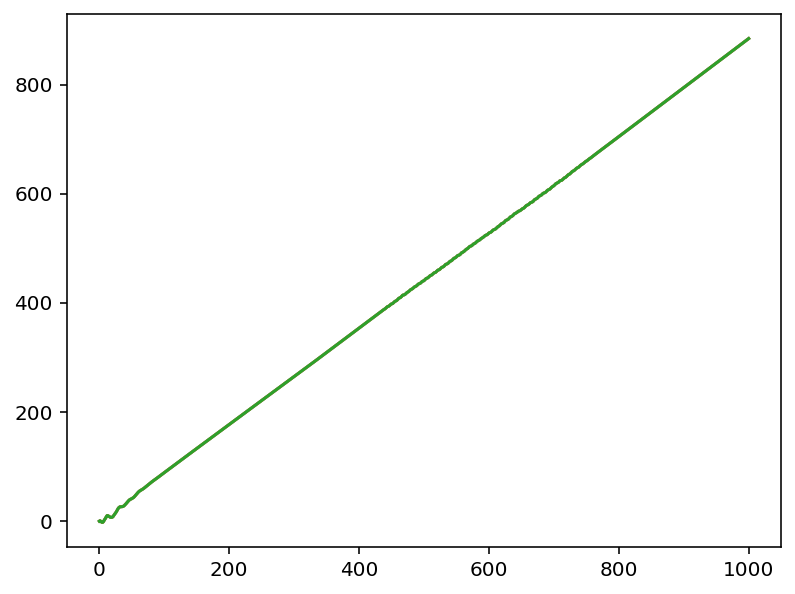

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.plot(np.cumsum(rewards))
plt.show()


In [24]:
rollout[0]

AttributeError: 'State' object has no attribute 'reward'

In [15]:
len(qs[0])

74

In [16]:
def plot_kinematics(qs, up_to, idx=-1, total_len=2000):
    fig = plt.figure(figsize=(5, 5))
    if idx == -1:
        qs = [r.q for r in rollout[:up_to]]
        for _idx in range(len(qs[0])):
            plt.scatter(up_to, qs[up_to-1][_idx], c="r")
    else:
        qs = [r.q[idx] for r in rollout[:up_to]]
        plt.scatter(up_to, qs[up_to-1], c="r")
        
    _ = plt.plot(qs, alpha=0.8)
    plt.xlim(0, total_len)
    plt.ylim(-1.15, 1.15)
    plt.axvline(x=up_to, c="r")
    
    plt.title(f"r.q[{idx}] Trajectory")
    fig.canvas.draw()
    graph = np.array(PIL.Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb()))
    graph = cv2.resize(graph, dsize=(500, 500), interpolation=cv2.INTER_CUBIC)
    return graph


def stack_vids(vids, qs, up_to=500, target_idx=2):
    concat_vids = []
    for idx, frame in tqdm(enumerate(vids[:up_to])):
        plot = plot_kinematics(qs, idx+1, idx=target_idx, total_len=up_to)
        total = np.hstack((frame, plot))
        concat_vids.append(total)
    return concat_vids

In [31]:
matplotlib.use('svg') 

In [19]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.

videos = stack_vids(vids, qs, target_idx=3)

500it [00:34, 14.58it/s]


In [20]:
media.show_video(videos, fps=30)

In [ ]:
graph.shape

In [ ]:
which = 2
front = 200
qs = [r.q[which] for r in rollout[:front]]
_ = plt.plot(qs, alpha=0.8)
plt.xlim(0, 2000)
plt.axvline(x=front, c="r")
plt.scatter(front, qs[front-1], c="r")
plt.title(f"r.q[{which}] Trajectory")